In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from keras.utils import np_utils

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Chargement data

In [2]:
data_wine = datasets.load_wine()

# Transformation du dataset en pandas dataframe
data_wine = pd.DataFrame(data= np.c_[data_wine['data'], data_wine['target']],
                     columns= data_wine['feature_names'] + ['target'])
# Affichage du dataset
data_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


## Séparation des données

In [3]:
X = data_wine.iloc[:, [0,12]].values
y = data_wine.iloc[:,[13]].values
y=np.ravel(y,order='C')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

## Optimisation: kernel et hyper-paramètre C / gamma

In [4]:
# Parametres a tester
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# Metriques a tester
scores = ['precision', 'recall']


for score in scores:
    print("# Optimisation des hyperparamètres pour %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Meilleurs paramètres:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) pour %r"
              % (mean, std * 2, params))
    print()

    print("Rapport de classification:")
    print()
    print("Le modèle est entraîné sur le jeu d'entraînement complet.")
    print("Les scores sont calculés sur le jeu d'évaluation complet.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Optimisation des hyperparamètres pour precision

Meilleurs paramètres:

{'kernel': 'linear', 'C': 10}

Grid scores:

0.679 (+/-0.243) pour {'gamma': 0.001, 'kernel': 'rbf', 'C': 1}
0.691 (+/-0.115) pour {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1}
0.573 (+/-0.117) pour {'gamma': 0.001, 'kernel': 'rbf', 'C': 10}
0.663 (+/-0.136) pour {'gamma': 0.0001, 'kernel': 'rbf', 'C': 10}
0.633 (+/-0.146) pour {'gamma': 0.001, 'kernel': 'rbf', 'C': 100}
0.663 (+/-0.152) pour {'gamma': 0.0001, 'kernel': 'rbf', 'C': 100}
0.711 (+/-0.071) pour {'gamma': 0.001, 'kernel': 'rbf', 'C': 1000}
0.737 (+/-0.177) pour {'gamma': 0.0001, 'kernel': 'rbf', 'C': 1000}
0.857 (+/-0.081) pour {'kernel': 'linear', 'C': 1}
0.874 (+/-0.105) pour {'kernel': 'linear', 'C': 10}
0.857 (+/-0.161) pour {'kernel': 'linear', 'C': 100}
0.849 (+/-0.105) pour {'kernel': 'linear', 'C': 1000}

Rapport de classification:

Le modèle est entraîné sur le jeu d'entraînement complet.
Les scores sont calculés sur le jeu d'évaluation complet

## Entraînement de la SVC avec hyper-paramètres optimisés

In [5]:
svc = SVC(kernel='linear', C=1).fit(X_train, y_train)

In [6]:
svc.score(X_test,y_test)

0.8135593220338984

## Création d'une meshgrid

In [7]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = (x_max / x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

## Affichage de deux paramètres

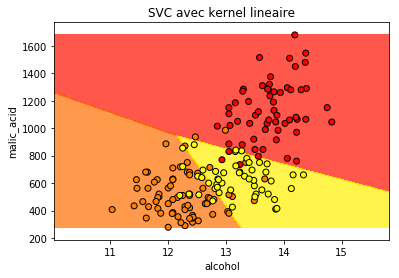

In [8]:
plt.subplot(1, 1, 1)
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.autumn, alpha=0.7)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.autumn,edgecolors='k')
plt.xlabel('alcohol')
plt.ylabel('malic_acid')
plt.xlim(xx.min(), xx.max())
plt.title('SVC avec kernel lineaire')
plt.show()